### Deep Learning Miniproject - Audio

AVS 8th Semester - Group 841

In [62]:
import pandas as pd

#from IPython.display import Audio
import IPython.display as ipd

from numba import jit
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
import pytorch_lightning as pl
import torchaudio as ta

#### 1. Explore the dataset through code

a. How many samples does the dataset contain?

In [28]:
#Load the data!
PATH = "./data/metadata_compiled.csv"
df = pd.read_csv(PATH)

#Check no. samples
print(f'Number of samples : {df.shape[0]}')

Number of samples : 27550


b. How many classes? How many samples per class? Show a histogram of the number of intances per class

In [29]:
print(f'Number of classes: {len(df["status"].unique())}.\n\
    Classes: {df["status"].unique()}\n\
    {pd.value_counts(df["status"], dropna=False)}')

Number of classes: 4.
    Classes: [nan 'healthy' 'COVID-19' 'symptomatic']
    healthy        12479
NaN            11326
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64


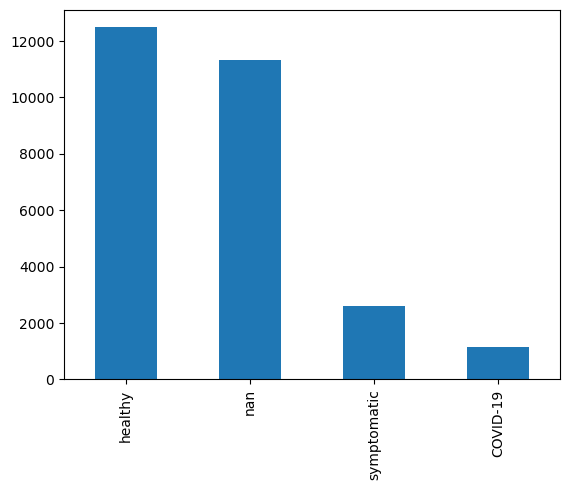

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [4]:
pd.value_counts(df['status'], dropna=False).plot.bar()
plt.show()

c. Play a random sample from each class

In [146]:
# playing healthy
healthy = df[df['status'] == 'healthy'].sample()['uuid'].item()
path = "./conv/" + healthy + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

In [100]:
# playing COVID-19
covid = df[df['status'] == 'COVID-19'].sample()['uuid'].item()
path = "./conv/" + covid + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

In [102]:
# playing symptomatic
symptomatic = df[df['status'] == 'symptomatic'].sample()['uuid'].item()
path = "./conv/" + symptomatic + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

d. Describe if/how you think the data distribution will affect training of a classifier

e. Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice

#### 2. Use a neural network of your own chose to classify the dataset. Explain your choice and at least one alternative. Document your experiences:.

#### Audio Spectogram Transformer Implementation

In [31]:
df_copy = df.copy()
df_copy = list(df_copy[pd.notna(df_copy['status'])]['status'])

In [51]:
df_copy[['uuid', 'status']]

,uuid,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,healthy
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,healthy
7,001d8e33-a4af-4edb-98ba-b03f891d9a6c,COVID-19
...,...,...
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,healthy
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,healthy
27544,fff13fa2-a725-49ef-812a-39c6cedda33d,healthy
27546,fff3ff61-2387-4139-938b-539db01e6be5,symptomatic


In [65]:
class DataModuleClass(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        #self.transform = transforms.MelSpectrogram(sample_rate)
        self.batch_size = 12
        self.tensor_list = []
        self.class_list = []
        self.audio_data_files = os.listdir('./conv/')[0:5]
        
        print("big list?", len(self.audio_data_files))
        #Define required parameters here
    
    def prepare_data(self):
        #print(self.audio_data_files.type())#oloop through audio_data_files
        for file in self.audio_data_files:
            waveform, sample_rate = ta.load('./conv/' + file)
            
            #print("Sound file: ", file)
            #file = filename.mp3
            
            self.tensor_list.append(waveform)
        print(self.tensor_list)
        self.class_list = list(df[pd.notna(df['status'])]['status'])[0:5]
        print(self.class_list)
        
        
        #Define steps that should be done
        #only on one GPU, like getting data

    def setup(self, stage=None):
        #Apply melSpectogram transform

        self.train_data, self.valid_data, self.test_data = random_split(self.tensor_list, [7,2,1], generator=torch.Generator().manual_seed(42))
        self.train_class, self.valid_class, self.test_class = random_split(self.class_list, [7,2,1], generator=torch.Generator().manual_seed(42))

        #Define steps that should be done on every GPU,
        #like splitting data, applying transform etc.

    def train_dataloader(self):
        return self.train_data, self.train_class
        #Return dataloader for training datahere

    def val_dataloader(self):
        return self.valid_data, self.valid_class
        #Retur   
    def test_dataloader(self):
        return self.test_data, self.test_class
    

In [67]:
class ASTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        #setup up each layer
        #self.l1 = nn.Linear(28 * 28, 10)
    def forward(self, x):
        pass

    def training_step(self, batch, batch_idx):
        x, y = batch

    def configure_optimizers(self):
        pass

In [68]:
s = DataModuleClass()
trainer = pl.Trainer()
model = ASTModel()

trainer.fit(model, s)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


big list? 5
[tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.2325e-06,
         -2.6507e-06, -1.0120e-06]]), tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0010, -0.0011, -0.0009]]), tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.7187e-06,
         -9.5628e-07, -1.9772e-06]]), tensor([[ 9.5632e-11, -9.8761e-09,  1.0393e-08,  ..., -1.0467e-02,
         -1.1224e-02, -8.1491e-03]])]
['healthy', 'healthy', 'healthy', 'healthy', 'COVID-19']


c:\Users\Kata\anaconda3\envs\deepl\lib\site-packages\pytorch_lightning\loops\utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
c:\Users\Kata\anaconda3\envs\deepl\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [92]:
#Transform audio file to spectogram
PATH = './conv/'
file_name = os.listdir(PATH)[0]
print(file_name)

audio_path = PATH + file_name
print(audio_path)

print("fucj")
y, sr = librosa.load(audio_path)
ipd.Audio(y, rate=sr)

#waveform, sample_rate = torchaudio.load(audio_path, normalize=True)



00039425-7f3a-42aa-ac13-834aaa2b6b92.mp3
./conv/00039425-7f3a-42aa-ac13-834aaa2b6b92.mp3
fucj


a. Discuss at least four relevant hyper-parameters

b. Experiment with the effect of different batch sizes

c. Experiment with the effect of different learning rates

d. Experiment with different number of network layers

e. Implement at least two data agumentation techniques

f. Discuss what influences the memory use of a solution such as yours. What can be done to reduce this?